In [2]:
import sys
# !{sys.executable} -m pip install pymed

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import urllib.request as urllib2
from tqdm import tqdm
import time
from pymed import PubMed
import utils


In [4]:
# Create a PubMed object that GraphQL can use to query
# Note that the parameters are not required but kindly requested by PubMed Central
# https://www.ncbi.nlm.nih.gov/pmc/tools/developers/
pubmed = PubMed(tool="MyTool", email="leehongkai@gmail.com")

# Create a GraphQL query in plain text
query = "Systemic Lupus Erythematosus Immune"

# Execute the query against the API
query_number = 10000
results = pubmed.query(query, max_results=query_number)
df_metadata = pd.DataFrame(columns=['pubmed_id', 'title', 'keywords', 'publication_date', 'abstract'], index=range(query_number))
_index = 0

# Loop over the retrieved articles
for article in tqdm(results, desc='Downloading abstracts...', unit=' articles', position=0):

    # Extract and format information from the article
    article_id = article.pubmed_id
    title = article.title
    publication_date = article.publication_date
    abstract = article.abstract
    
    # append information about the article
    df_metadata.at[_index, 'pubmed_id'] = article_id
    df_metadata.at[_index, 'title'] = title
    df_metadata.at[_index, 'publication_date'] = publication_date
    df_metadata.at[_index, 'abstract'] = abstract
    
    try: 
        if article.keywords:
            if None in article.keywords:
                article.keywords.remove(None)
            keywords = '", "'.join(article.keywords)
            df_metadata.at[_index, 'keywords'] = keywords

    except AttributeError:
        continue
        
    _index += 1


In [5]:
df_metadata = df_metadata.dropna(axis=0, how='all')

In [15]:
words = []
for text in df_metadata.abstract:
    # get list of words
    if text:
        wordsFromText = utils.preprocess(text)
        words += wordsFromText

In [16]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 622789
Unique words: 3175


In [17]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[11, 2, 0, 11, 4, 9, 2, 4, 1, 0, 11, 2, 4, 1, 11, 0, 11, 4, 11, 2, 0, 4, 1, 1, 1, 4, 0, 2, 11, 2]


In [18]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[7, 231, 231, 151, 42, 231, 4, 999, 0, 999, 999, 1867, 2325, 820, 37, 1868, 15, 2325, 820, 16, 820, 1867, 2, 2325, 820, 0, 1868, 1868, 820, 136]


In [46]:
def get_target(words, idx, window_size=10):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [47]:
def get_batches(words, batch_size, window_size=10):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [48]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 1, 3, 0, 1, 2]


In [49]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [50]:
import torch
from torch import nn
import torch.optim as optim

In [51]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [52]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 50


In [53]:
# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 50):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

lupus | hpv, pin1, dcs, oncogenes, -1
ifn | proteins, tgf-β, il-15, nk, bovine
group | toxoplasma, g3bp, gene-i, ada2, movement
with | mln, mtor, anti-smd183-119, rabbit, pr
2 | pai-1, evs, virus, h1, morbidity
< | cd28, regression, tcc, ozanimod, animal
or | u, gba, ancestral, nat-2, tofacitinib
by | controls, fcgammariib, c4bp, serum, sf
cd28 | <, mif, microrna-155, ptsd, synthesis
mdscs | autoabs, kfd, parameters, exposed, disease
salivary | hcrptg/bw, inhibitor, 30, numbers, netosis
pg | against, transitional, decreased, pcp, hsp60
sledai | snrnp, 25, tlr-4, secondary, captopril
tnfα | high-dose, epa, immunoproteasome, c57bl/6, il-1
kinase | atrial, inhibitors, fsp-1, glutamate, seric
herpes | sucrose, treated, a1, hla-dr3, lmp2a
...
is | b, trap, mir-150, counts, ana
cr1 | cicam-1, premature, δep, titres, increased
il-2 | disorders, prkcb, inhibitor, rv, developed
de | itregs, hct, peg-ic, hiv-1, thymus
ln | iga, nets, fcgammariia, will, maternal
cells | lower, migration, and/or, 

1 | se-cadherin, tbm, adjusted, parvovirus, cd200
mice | healing, histopathologic, ldl, incidents, resistance
levels | rs181206, cic, notch1, including, supar
that | tubular, full, bm12, resistance, trnas
d | se, population, sjs, loss, clec16a
cd4 | a/g, ms, surface, memory, lrp2
are | circulating, urinary, perfusion, exposed, involvement
diseases | adjuvants, bay11, %, pcos, nbd
ctd | sle, zinc, on, activities, viruria
nzm | -14, hrv, mc, anti-ro/ssa, anti-hla
tlr2 | 5-hmc, bsg, mp-ic, 6-tgn, ri
sle1b | ad-mscs, ifn-λs, é, cr3, hcq
cics | e-cr1, quercitrin, dlbcl, rates, fsp-1
fli1 | 95%, hae, ebna-1, ici, wg
positivity | capillaroscopic, females, mir-181a, cicam-3, fixed
kinase | atrial, glutamate, fsp-1, seric, sphk1
...
cr1 | cicam-1, titres, ldl, casein, δep
renal | matrix, light, oxide, mtg, hearing
serum | hyperprolactinemia, kc, therapy, اللثة, backgrounds
n | lilrb4, chabaudi, neonates, isozyme, using
apoptotic | cytopenias, c-flip, tada, s1p, sirolimus
<COMMA> | ox-ldl, secon

glomerular | cryoglobulins, sct, c1q-binding, replacement, spironolactone
dcs | lv, 95%ci=0, fibrin, anti-hsf1, cd4+t
ic | igan, التهاب, genotypes, anticoagulants, mrl-ipr/ipr
apoptotic | cytopenias, immunoglobulin, mir-146a, findings, crt
il-2 | inhibitor, developed, prkcb, tpo, database
levels | rs181206, including, dectin-1, notch1, cic
ln | nets, é, iga, anti-pf4, fcgammariia
by | c4bp, caspase-1-/-, sf, periodontal, trimester
die | allele, intestinal, -armepavine, sle1b, interferons
total | pae, vasculitis, atherosclerosis, huplt, un
vsv | gastritis, expanded, non-dpp4i, iv, exon
gal-8 | asct, cyclosporine, anti-pf4, mrl27, mx-68
and/or | functions, stress, pkc, repo, database
editing | igh, itreg, t, activin-a, h-2b
fcgr2b | americans, butyrate, remission, n-protein, np
imds | ecp, hemorrhagic, cs, atsa, interstitial
...
il-2 | developed, inhibitor, prkcb, tpo, particles
skin | quercitrin, bs, ah, wsx-1, exposed
monocytes | chorea, il-1, granulomatosis, netosis, bands
gene | ttp,

treatment | malat1, com, subsets, capnon, scale
monocytes | granulomatosis, haat, chorea, il-1, bands
binding | adamts13, asct, am14, hemopoietic, smica
+/- | thromboxane, hrqol, miu/ml, hns, hsps
p | physicians, diabetes, rosacea, non-fermenting, carriers
il-2 | inhibitor, developed, 7, tpo, increased
to | otud1, ctx, efas, let-7a, transgenic
was | cultures, ps, anti-gd1b, lpr, farr
population | seizures, d, p16, t-cell, <SEMICOLON>
die | allele, intestinal, -armepavine, sle1b, curcumin
trem-1 | signaling, nucleosome, iris, cc1qr/car, sct
sepsis | tlr-2, prognosis, anti-nrnp/sm, protein-losing, allele
hypocomplementemia | aat, secretion, vimentin, ova, alu
vsv | gastritis, t-cell, non-dpp4i, 56r, und
odn | fc-igg, bm1, igg3, granulomatosis, molecules
scd25 | itreg, cec, atypical, oh, concentrations
...
risk | dose, slandcs, rfx1, rbcs, com
or | atp, u, trimester, tofacitinib, excretion
cell | plr, mac-1, along, nfκb, lines
systemic | rs153109, dermatofibromas, meta-analysis, <SEMICOLO

gene | ttp, relapse, twins, aplastic, iu/ml
apoptotic | mir-146a, immunoglobulin, phlebotomy, crt, ferritin
glomerular | sct, cryoglobulins, apoa-i, 30, prognosis
ifn | bcl-xl, iii, imd, species, mzl
cells | lower, atcc, -1, balb/c, sls
lupus | huscd32, anti-ro52, trex1, oncogenes, i3c
c1q | exposure, reactions, hla-dr2, a49g, gravis
sle | tsrnas, sfkn, proportions, atopic, cd86
anti-gbm | animals, fgfr-1, anti-fcepsilonrialpha, pcna, gn
tbk1 | pbmc, ain, jkap, hla, neutrophil
caffeine | pre-naïve, genotype, pfoa, pd1, mddcs
gal-8 | asct, mrl27, ki, complement, cyclosporine
vpa | donors, not, monkeys, immunosuppressant, maculopathy
tlr2 | bsg, 5-hmc, mp-ic, lpr/lpr, dm
nzm2328 | mg, dams, mice, 25-dihydroxyvitamin, aps
slc15a4 | disorders, ig, la, apo, fish
...
type | ifns, p50, ha-igg, i, activin-a
complement | mzl, ω-3, tmmp-9, spa, tls
with | hospital, gsl, anti-smd183-119, ccr4, average
systemic | rs153109, dermatofibromas, unaffected, meta-analysis, <SEMICOLON>
disease | nfκb, deo

sle | sfkn, tsrnas, cd86, iic, fibrin
autoimmune | method, anti-cd4, tsdr, intrarenal, igh
cr1 | fcγriiia, casein, cicam-1, dengue, embolism
for | movement, wegener's, trail, brain, samples
baff | pka, rs1049564, child, anaphylaxis, consumption
skin | quercitrin, wsx-1, ah, fcgammar, neuropsychiatric
patients | sema3a, cold, rheumatoid, ts, mnc
by | c4bp, uvb, mtg, caspase-1-/-, trimester
air | cytometry, capillaritis, conjunctival, t-ig, smd1
aplastic | consumption, c5b-9, gene, pon1, polyadenylation
thymus | thymectomy, population, score, ctl, celiac
oh | 2d3, different, pih, c1s, related
cort | nk, leptin, b-cell, hpv-b19, sjögren's
stimulation | percentage, following, lh, reg, sod1
odn | bm1, fc-igg, samples, polyadenylation, scd8
helper | igm-ic, tyk2, nkt, occured, dendritic
...
< | mit, 001, score, obese, animal
was | cultures, nu/nu, suppressor, pemphigoid, ps
for | movement, wegener's, trail, brain, bv
is | immunopathological, visual, affinity, atcc, dietary
that | full, migra

i | rp, u, bx471, δep, atp
diseases | pt, even, ctla-4ig, mrnas, sib
in | apheresis, crescentic, hla-dr2, il-25, dif
and | hsp65, adiponectin, cxcl7, tc, naigg
1 | [2, los, cluster, lag, ifns
n | gbs, chabaudi, obese, antiphospholipid, 01
anti-dna | tbp, relatives, immunized, clonal, rabbits
genes | tri, tb, types, cd30, identified
dr3 | nzm2328, c1, es, tnf-α, mtdna
cics | ige-containing, fsp-1, colitis, helical, synovial
americans | sledai, la48, titres, mirnas, trex1
ifn-beta | il-27, il-8, thrombocytopenia, respiratory, nnav
aplastic | c5b-9, subclinical, consumption, rs1883832, pon1
cd4+cd25-foxp3+ | ssc-ics, malaria, sections, a1-a1, dermatofibromas
igg3 | tmmp-9, april, fcrgamma, gammadelta, gamma
il-33 | jsle, plwh, jak, or=0, sil-2r
...
risk | factors, cad, rfx1, csf, rbcs
<QUOTATION_MARK> | immunotherapy, anticoagulant, ige-containing, auto-immune, capnon
gene | ttp, relapse, twins, nuclei, vegf-a
or | excretion, vitro, vpa, obese, cxcl4
type | pathogenic, p50, species, ifns,

or | vitro, excretion, lis, vpa, inh-odns
cell | nfκb, lines, let-7i, hct, tcrbeta
was | pemphigoid, cultures, maturation, ps, no
t | psa, γδ, cd70, wbf1, rhsp70
skin | quercitrin, wsx-1, neuropsychiatric, hsps, fcgammar
genes | types, tri, identified, trnas, tb
n | gbs, 01, obese, aqp4-igg, me
<QUOTATION_MARK> | immunotherapy, anticoagulant, auto-immune, ige-containing, capnon
stimulation | percentage, following, miu/ml, lh, fsh
mdscs | local, caspase-1-/-, antibody, these, bacterial
cnv | bcd, b19, mirnas, cd74, staining
sepsis | peroxide, hydrogen, arterial, kfd/sle, stiffness
heparan | p-res, m-1, metabolite, mmol/l, mvs
nzm | dc, antagonists, -14, relapse, c4b
immunosuppressive | during, infection, depressed, rs3758391, il-1β
fcgr2b | nzbw, motif, dna-reactive, d3tx, n-protein
...


In [54]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [55]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [56]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

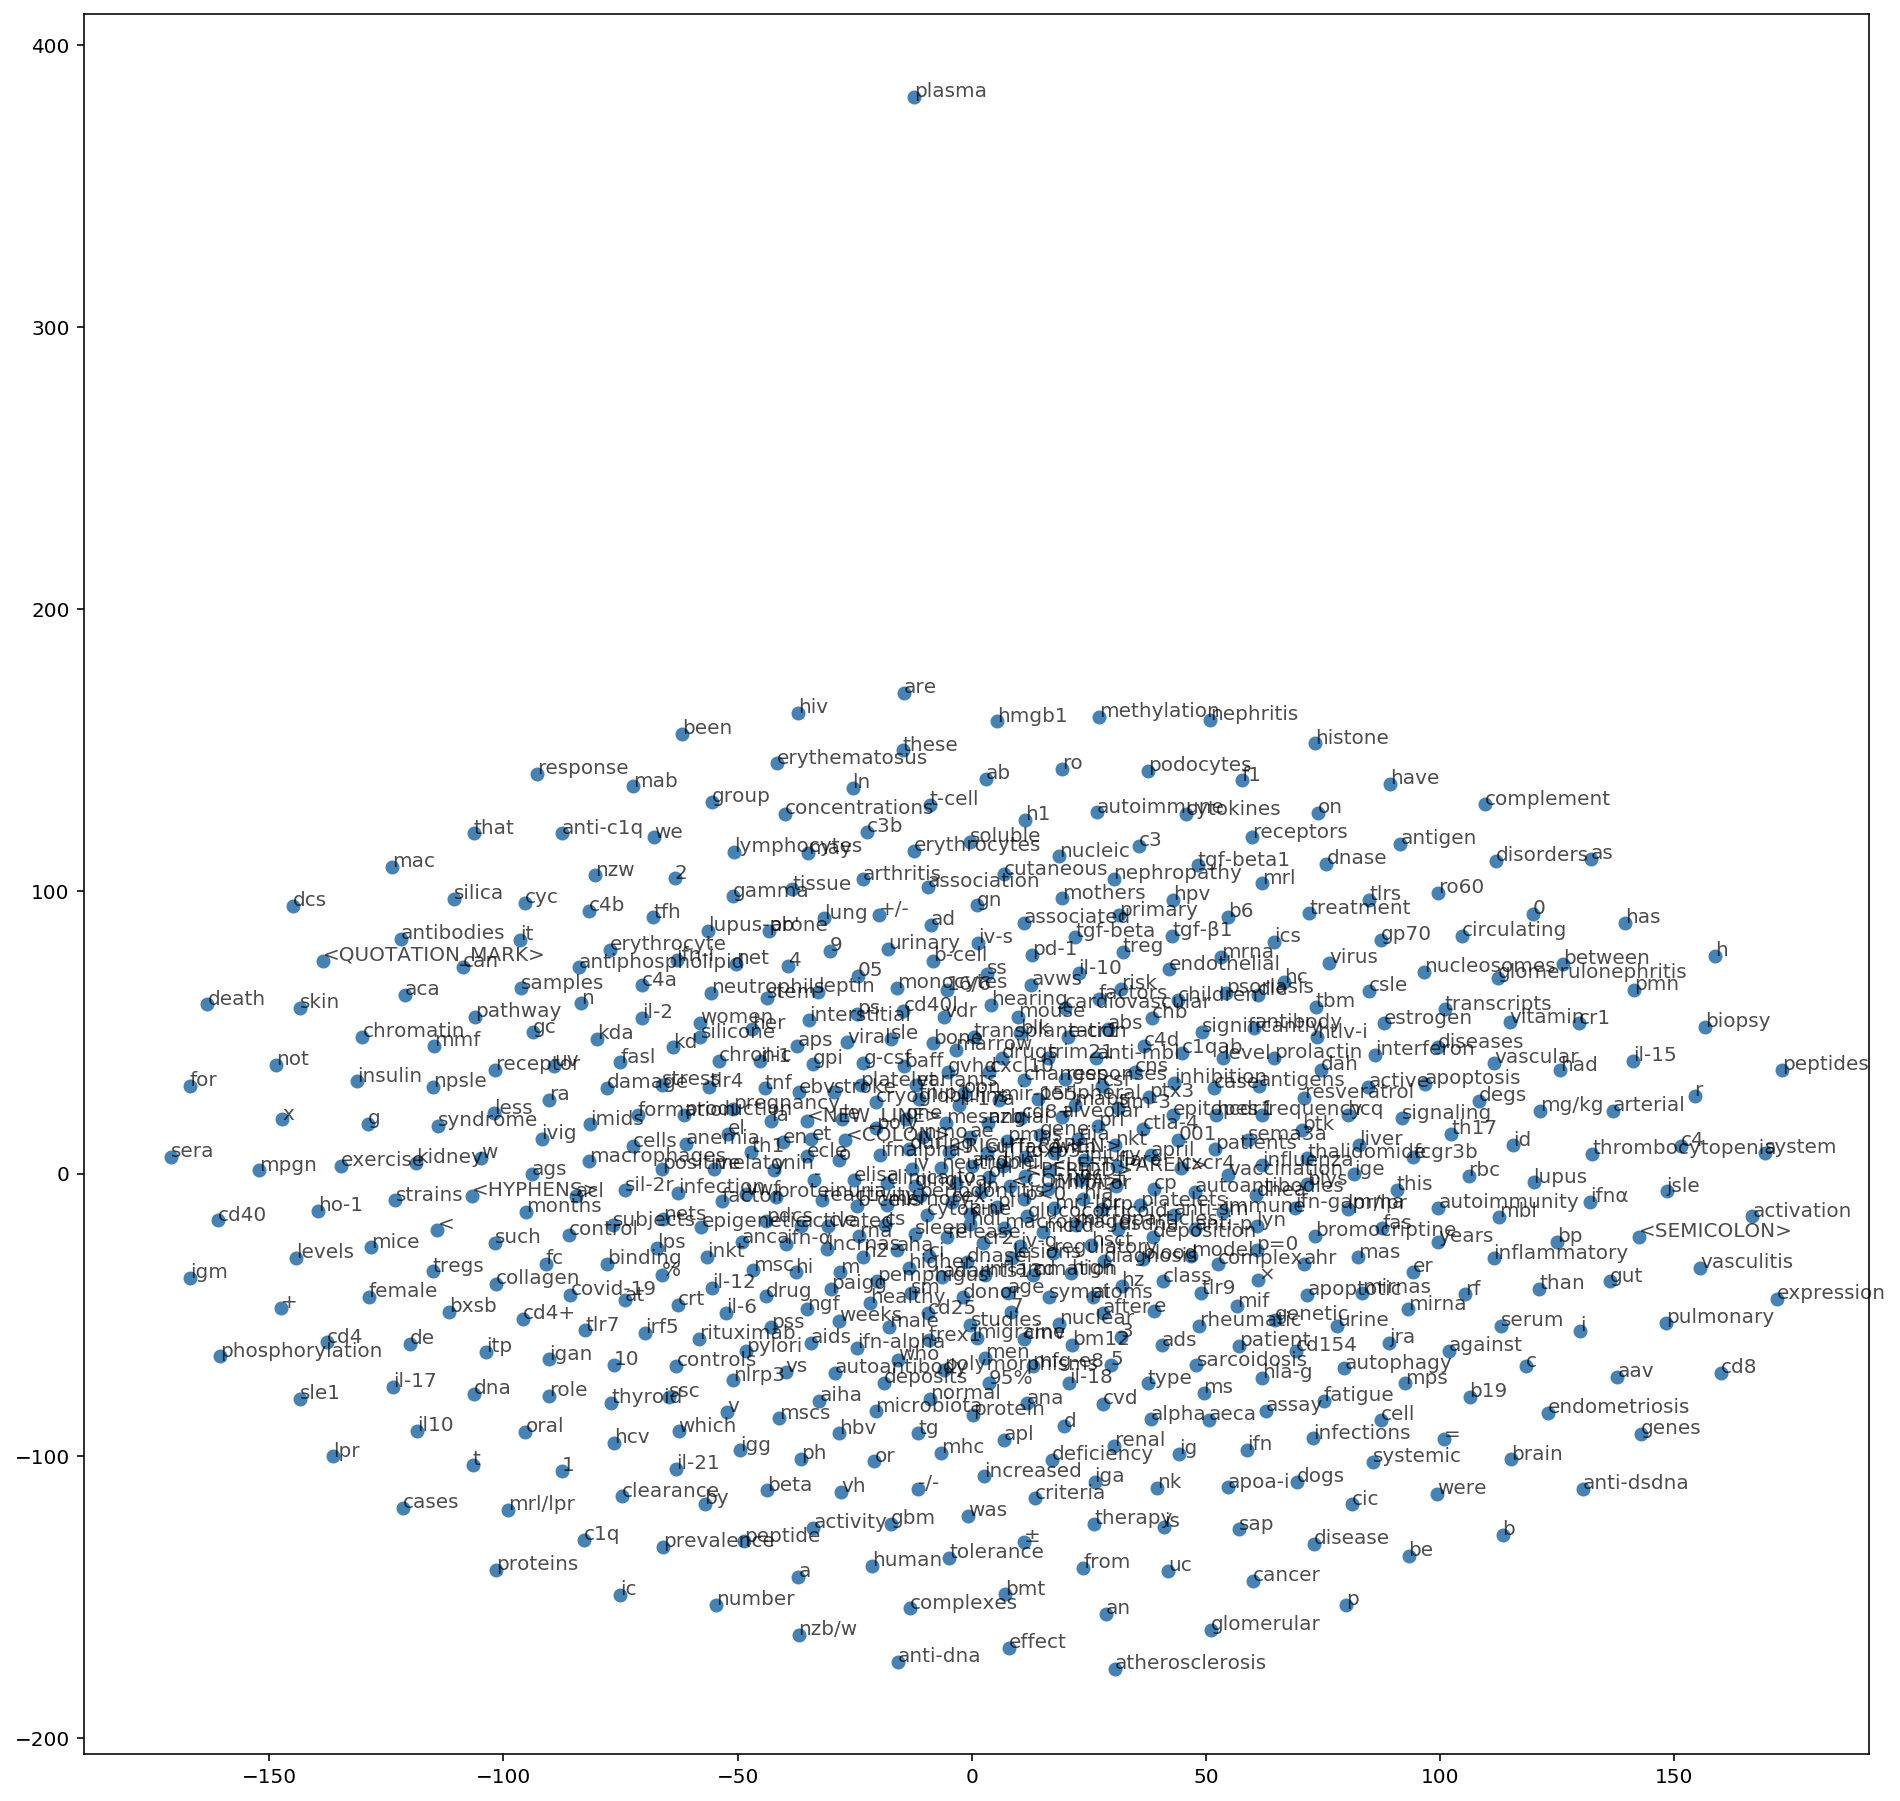

In [57]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [59]:
vocab_to_int['interferon']

241

In [70]:
17//2

8

In [73]:
def cosine_similarity_predict(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    
    valid_examples = np.array([241])
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [76]:
# getting examples and similarities      
valid_examples, valid_similarities = cosine_similarity_predict(model.embed, device=device)
_, closest_idxs = valid_similarities.topk(10) # topk highest similarities
            
valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
for ii, valid_idx in enumerate(valid_examples):
    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
    print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))

interferon | pb-igg, vla4, taurine, gag, sle2c2, scores, exercise, conjunctival, fd
hypocomplementemia | hodgkin, hiap, day, elements, nephropathy, tlr-9, t-regs, ifng, count
helper | lap, tyk2, occured, tubulo-interstitial, gp120, ivgg, hpv, -14, cd84
pparγ | females, mirna, rs153109, cd40, different, therapeutic, irf-1, cd40l, filtration
kinase | casein, k-76, epitopes, pn, mir-150, lair-1, b19, ama, asle
fcgr2b | nzbw, motif, dna-reactive, d3tx, n-protein, sjia, hsv, balb/c, bx471
childhood | notch1, exposure, farm, analysis, abuse, adult, th17, atd, mia
imds | ischemic, hospitalization, hemorrhagic, stroke, balf, chd, interstitial, ecp, hct
ifn-beta | ship-1, il-27, thrombocytopenia, retinal, hospital, il-8, evs, vasculitis, nnav
